# Inference and Validation

훈련된 모형을 사용하여 prediction을 수행할 수 있다. 이것을 **inference**라고 부른다. 이 과정에서 훈련 데이터에 대해 과대적합이 일어날 수 있는데 이것을 **overfitting**이라고 한다. overfitting를 확인하기 위해서 훈련데이터를 **validation** set으로 나눈다.  overfitting 문제를 해결하기 위해서 regularization(규제화) 또는 dropout을 수행한다.  훈련을 진행하는 과정에서 validation performance 를 모니터링하여 overfitting이 발생하는지 확인할 수 있다.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('TensorFlow version:', tf.__version__)
print('tf.keras version:', tf.keras.__version__)
print('Running on GPU' if tf.test.is_gpu_available() else 'GPU device not found. Running on CPU')

Using:
TensorFlow version: 2.3.0
tf.keras version: 2.4.0
GPU device not found. Running on CPU


## Load the Dataset

Fashion-MNIST dataset을 load 한다. 이번 예제에서는 전체 데이터를 train dataset, validation dataset, test dataset으로 나눈다.

`train`은 60,000 examples을 포함하고 `test` 는 10,000 examples을 포함하고 있다.

train dataset에서 일부 10,000 건의 example을 별도의 validation dataset으로 지정한다. 


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

## 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보자. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여준다. 각 이미지는 28x28 픽셀로 표현된다:

In [6]:
x_train.shape

(60000, 28, 28)

비슷하게 훈련 세트에는 60,000개의 레이블이 있다:

In [7]:
len(y_train)

60000

각 레이블은 0과 9사이의 정수이다:

In [8]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있다. 이 이미지도 28x28 픽셀로 표현된다:

In [9]:
x_test.shape

(10000, 28, 28)

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있다:

In [10]:
len(y_train)

60000

### 데이터 전처리

In [11]:
# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

###  validation dataset

In [12]:
# Reserve 15,000 samples for validation
x_val = x_train[-15000:]
y_val = y_train[-15000:]
x_train = x_train[:-15000]
y_train = y_train[:-15000]

In [13]:
num_training_examples = len(x_train)
num_validation_examples = len(x_val)
num_test_examples = len(x_test)

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

There are 45,000 images in the training set
There are 15,000 images in the validation set
There are 10,000 images in the test set


In [14]:
# fashion MNIST dataset class name
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Create Pipeline

In [15]:
x_train = x_train.reshape(num_training_examples, 28, 28,1)
x_val = x_val.reshape(num_validation_examples, 28, 28,1)
x_test = x_test.reshape(num_test_examples, 28, 28,1)

training_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [16]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build the Model



In [17]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Evaluate Loss and Accuracy on the Test Set

Evaluation은 모형을 훈련하면서 training set에 속하지 않은 데이터(validation dataset)를 사용하여 모형의 performance를 확인하는 것이다. 

In [19]:
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

157/157 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.0838

Loss on the TEST Set: 2.303
Accuracy on the TEST Set: 8.380%


모형이 훈련되지 않았으므로 accuracy는 대략 10% 내외가 된다.

## Train the Model with the Validation Set

앞서 예제와 같은 방법으로 모형을 훈련할 수 있다. 

매 training epoch 마다 training set과 validation set에 대한 loss를 계산한다. 이를 통해 모형의 학습 과정을 모니터링 할 수 있다. validation set은 모형의 훈련에 사용되지 않는다. 대신 모형이 overfitting 되지 않는지를 확인할 수 있다.

`.fit` method 에서 `validation_data=validation_batches` argument에서 validation set을 지정하여 수행한다.

In [20]:
EPOCHS = 40

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data=validation_batches)

Epoch 1/40
704/704 [==============================] - 4s 5ms/step - loss: 0.9030 - accuracy: 0.6495 - val_loss: 0.6364 - val_accuracy: 0.7651
Epoch 2/40
704/704 [==============================] - 4s 5ms/step - loss: 0.5805 - accuracy: 0.7840 - val_loss: 0.5353 - val_accuracy: 0.8055
Epoch 3/40
704/704 [==============================] - 4s 6ms/step - loss: 0.5015 - accuracy: 0.8176 - val_loss: 0.4945 - val_accuracy: 0.8247
Epoch 4/40
704/704 [==============================] - 4s 6ms/step - loss: 0.4538 - accuracy: 0.8346 - val_loss: 0.5119 - val_accuracy: 0.8119
Epoch 5/40
704/704 [==============================] - 4s 6ms/step - loss: 0.4250 - accuracy: 0.8444 - val_loss: 0.4387 - val_accuracy: 0.8403
Epoch 6/40
704/704 [==============================] - 4s 5ms/step - loss: 0.4033 - accuracy: 0.8519 - val_loss: 0.4926 - val_accuracy: 0.8193
Epoch 7/40
704/704 [==============================] - 4s 5ms/step - loss: 0.3828 - accuracy: 0.8592 - val_loss: 0.4383 - val_accuracy: 0.8337
Epoch 

## Loss and Validation Plots

위에서 40 epoch 으로 모형을 훈련하였다. 훈련 결과를 시각화하여 표현해 보자. 

해당 결과를 확인해 보면 validation set에 대한 loss보다 training dataset에 대한 loss는 매우 작은 것을 볼 수 있는데 이를 통해 해당 모형이 overfitting 되었다고 판단할 수 있다. 

모형이 훈련될 때 training set 과 the validation set 모두에 대해 loss 와 accuracy 를 확인한다. `.fit` method는 `history` object를 리턴한다. `history.history` 속성은 **dictionary**로  training accuracy 와 loss 를 각 epochs 마다 기록한다.  

In [21]:
# Check that history.history is a dictionary
print('history.history has type:', type(history.history))

# Print the keys of the history.history dictionary
print('\nThe keys of history.history are:', list(history.history.keys()))

history.history has type: <class 'dict'>

The keys of history.history are: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


`history.history` dictionary 를 plot으로 시각화 하면 해당 모형이 훈련되는 과정에서 loss와 accuracy를 확인할 수 있다.

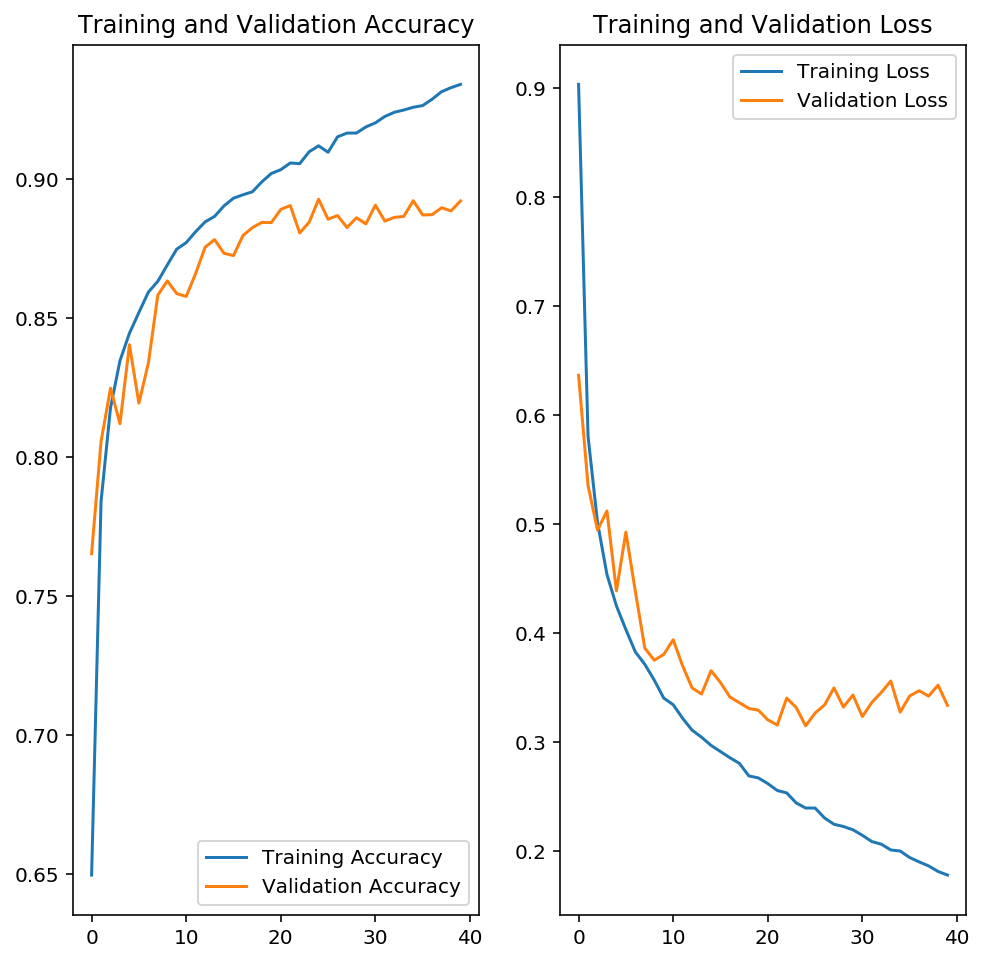

In [22]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Early Stopping

overfitting 문제를 해결하는 방법 중 하나가 Early Stopping이다. 
overfitting이 되면 모형이 일반화(generalize)에 실패하여 train set에 대해서는 과대 적합되고 validation set에는 오히려 정확도가 떨어지게 된다.

시각화 결과를 살펴보면 훈련 시작시 validation loss가 감소하기 시작하고 몇 epoch 이후에는 평준화되고 이후 증가하기 시작한다는 것을 알 수 있다. 

이때 overfitting이 발생하기 전에 훈련을 조기 종료하는 방법이 Early Stopping이다. 

**early-stopping**을 하기 위해서 `tf.keras`에서는 **callback**을 사용한다. `.fit()` method 에서 `callbacks` keyword argument를 사용한다. 

```python
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
```

* `monitor` argument : training을 종료하기 위해서 모니터링할 성능 지표를 지정한다. 
* `patience` argument : 정해진 epoch 수 모니터링 지표가 상당한 개선이 이루어지지 않으면 훈련을 중단한다. 
* `min_delta` argument :  개선된 것으로 판단할 수 있는 최소값을 지정한다. 

참고) [EarlyStopping 
documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping#class_earlystopping).

In [23]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/100
704/704 [==============================] - 4s 5ms/step - loss: 0.8791 - accuracy: 0.6681 - val_loss: 0.6817 - val_accuracy: 0.7529
Epoch 2/100
704/704 [==============================] - 4s 5ms/step - loss: 0.5811 - accuracy: 0.7868 - val_loss: 0.5244 - val_accuracy: 0.8079
Epoch 3/100
704/704 [==============================] - 4s 5ms/step - loss: 0.4949 - accuracy: 0.8189 - val_loss: 0.5010 - val_accuracy: 0.8181
Epoch 4/100
704/704 [==============================] - 4s 5ms/step - loss: 0.4506 - accuracy: 0.8336 - val_loss: 0.4450 - val_accuracy: 0.8363
Epoch 5/100
704/704 [==============================] - 4s 5ms/step - loss: 0.4205 - accuracy: 0.8450 - val_loss: 0.4188 - val_accuracy: 0.8447
Epoch 6/100
704/704 [==============================] - 4s 5ms/step - loss: 0.3983 - accuracy: 0.8543 - val_loss: 0.4296 - val_accuracy: 0.8421
Epoch 7/100
704/704 [==============================] - 4s 5ms/step - loss: 0.3744 - accuracy: 0.8626 - val_loss: 0.4200 - val_accuracy: 0.8506

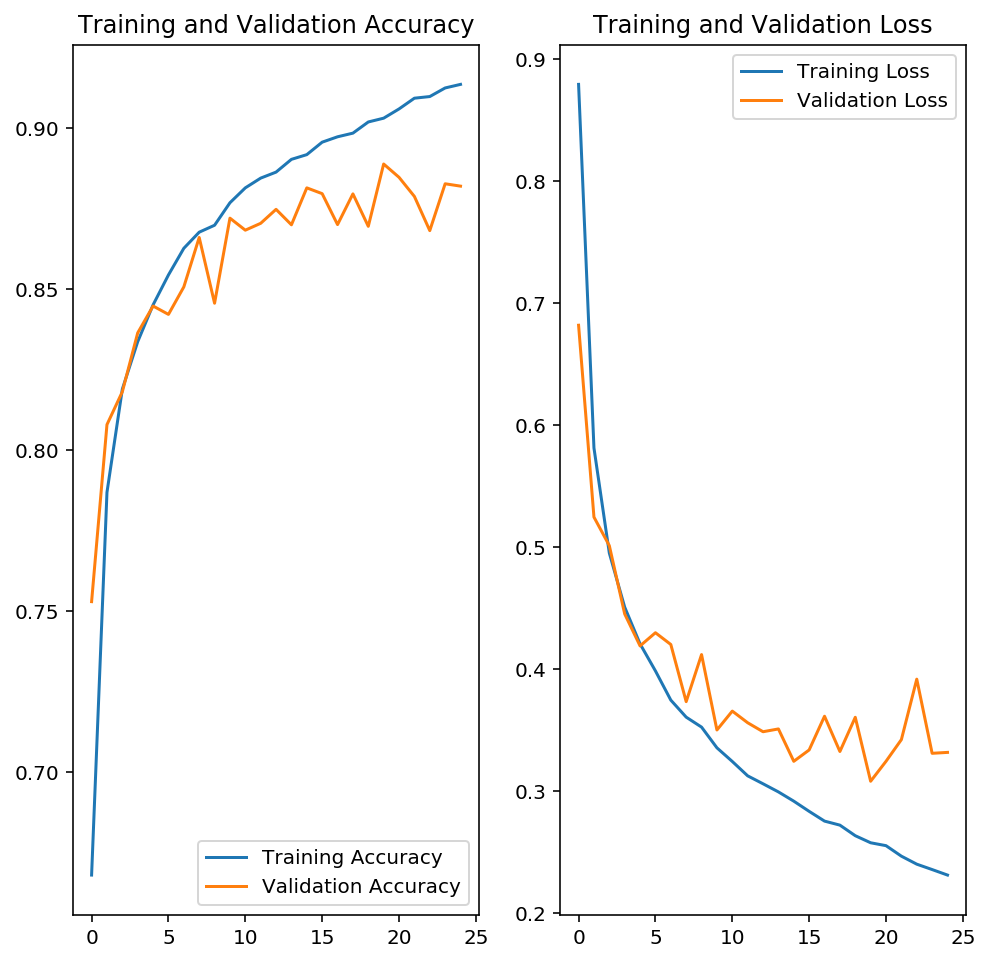

In [24]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Dropout

overfitting 을 해결할 수 있는 또다른 방법으로는  **dropout**이 있다. dropout 은 모형의 훈련과정에서 random하게 network의 일부 neurons을 삭제하는 것이다.  `tf.keras`에서는 `tf.keras.layers.Dropout()` layers 를 활용한다. 

```python
tf.keras.layers.Dropout(rate)
```

* rate : 훈련 중 임의로 삭제할 neuron의 비율을 지정한다. (0~1사이의 값)

input layer에 대해서는 dropout을 지정하지 않는다. 또한 훈련과정에서만 dropout 이 적용되고 훈련이 끝난 모형을 prediction에 사용할때는 dropout이 적용되지 않는다. 

> **Exercise:** 이전에 생성한 모형에 3개의 dropout layers를 추가한다. 이때 `rate=0.2`로 지정하시오. 그리고 해당 모형을 다시 훈련시키고 overfitting 이 해결되는지 확인해 보시오.

In [25]:
## Solution


## Inference

훈련된 모형을 사용하여 prediction을 수행하고 해당 결과를 시각화 하며 표현해 본다.

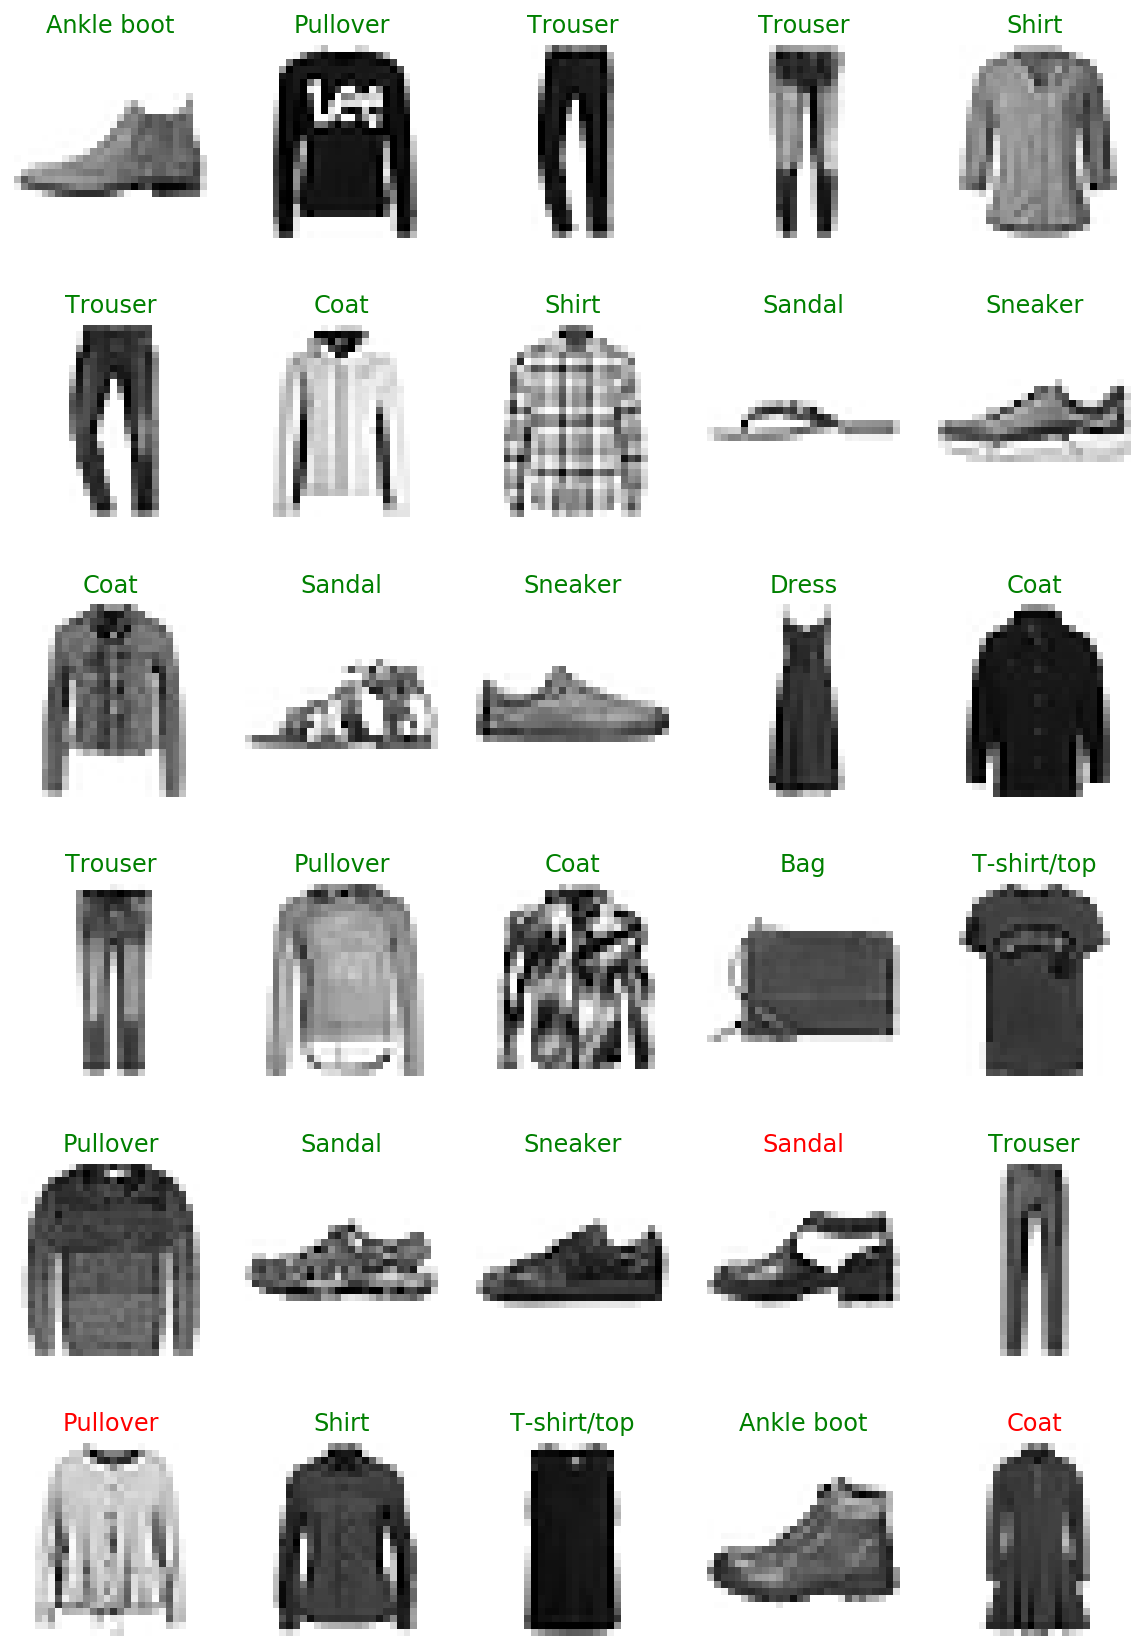

In [26]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()


plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')